### データの前処理

外れ値処理や特徴量の作成など、モデル構築に必要な前処理を行う

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import warnings
warnings.filterwarnings('ignore')

- データの読み込み

In [7]:
# 1_データの可視化で作成したデータを使用
df = pd.read_csv("./output/1/dosing_data_added.csv")
df.collectiondatetime = pd.to_datetime(df.collectiondatetime)

---
### 1. 外れ値処理

可視化したりツールを使用したりして外れ値を検出し、それが本当に外れ値なのかを検討する。  
個々では具体例として、原水色度の外れ値処理を行う。  

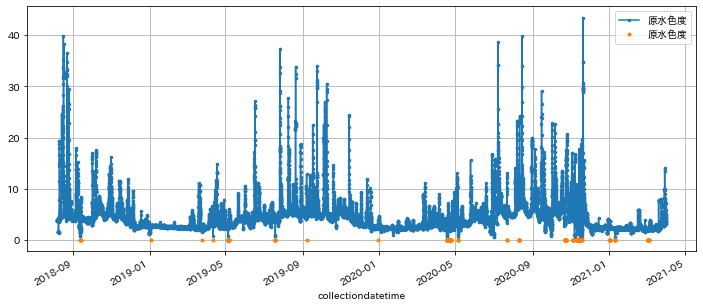

In [8]:
# 具体例：原水色度
fig = plt.figure(figsize=(12,5))
axes = fig.subplots(1,1)

df[df["原水色度"] != 0].plot(x="collectiondatetime", y=["原水色度"], figsize = (12, 5), ax=axes, style=".-", markersize=5)
df[df["原水色度"] == 0].plot(x="collectiondatetime", y=["原水色度"], figsize = (12, 5), ax=axes, style=".")
plt.grid()

上は原水色度の推移図で、原水色度が0の点を色を変えて強調表示している。  
原水色度自体は色の透明度を表す指標なので0となることはあり得るため、「色度が0 = 外れ値」とは言えない。  
しかし、前後の計測値から明らかに外れた点（2019-09付近など）は、そのような急激な変化が起こる確率を考えると外れ値である可能性が高い。

In [9]:
# 2019-09付近の色度=0の点における色度の値をnp.nanに置換
df.loc[(df["原水色度"] == 0) & \
       (df.collectiondatetime >= "2019-09") & (df.collectiondatetime <= "2019-10"), 
       "原水色度"] = np.nan

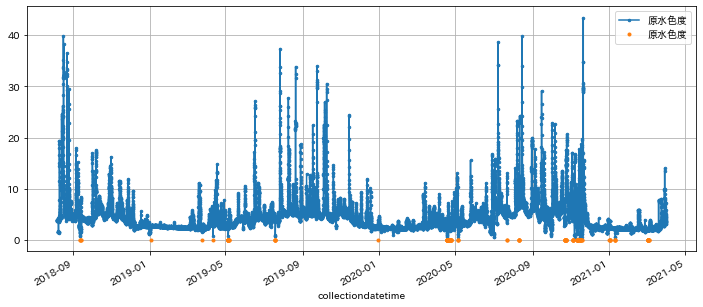

In [10]:
# 再度プロットして除去した点が消えていることを確認
fig = plt.figure(figsize=(12,5))
axes = fig.subplots(1,1)

df[df["原水色度"] != 0].plot(x="collectiondatetime", y=["原水色度"], figsize = (12, 5), ax=axes, style=".-", markersize=5)
df[df["原水色度"] == 0].plot(x="collectiondatetime", y=["原水色度"], figsize = (12, 5), ax=axes, style=".")
plt.grid()

---
### 2. 時間遅れを考慮した特徴量の作成

沈殿水水質を予測するには、その時刻の沈殿水水質に影響を与えた原水水質のデータを用いる必要がある。  
沈殿水水質が何時間前の原水水質から影響を受けているのかを考え、○○時間前の原水水質や薬品使用率を特徴量として作成する必要がある。  

ここでは1時間前の原水水質と薬品使用率を特徴量として作成する。

In [11]:
# 1時間前の特徴量を作成する項目を指定する
target_cols = ["原水濁度", "原水温度", "原水pH", "原水色度", # 原水水質
               "PAC注入率", "前苛性ソーダ注入率", # 薬品使用率
               "取水流量積算"]

# 1時間前の特徴量を作成する
for col in target_cols:
    df[col+"_shift1"] = df[col].shift(1)

In [12]:
# 確認
df.head()

,collectiondatetime,ろ過水残塩,原水濁度,原水色度,原水pH,原水温度,取水流量積算,沈殿水濁度,浄水色度,ろ過水濁度,...,配水流量積算,PAC注入率,前苛性ソーダ注入率,原水濁度_shift1,原水温度_shift1,原水pH_shift1,原水色度_shift1,PAC注入率_shift1,前苛性ソーダ注入率_shift1,取水流量積算_shift1
0,2018-08-07 00:00:00,0.03,0.86,3.91,7.34,15.5,87.0,0.22,0.0,0.0,...,63.0,61.149425,4.252874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-08-07 01:00:00,0.03,0.86,3.92,7.32,15.4,86.0,0.22,0.0,0.0,...,62.0,61.511628,4.186047,0.86,15.5,7.34,3.91,61.149425,4.252874,87.0
2,2018-08-07 02:00:00,0.03,0.81,3.92,7.35,15.3,87.0,0.23,0.0,0.0,...,61.0,59.655172,4.022989,0.86,15.4,7.32,3.92,61.511628,4.186047,86.0
3,2018-08-07 03:00:00,0.19,0.81,3.88,7.39,15.2,86.0,0.22,0.0,0.0,...,61.0,60.348837,4.069767,0.81,15.3,7.35,3.92,59.655172,4.022989,87.0
4,2018-08-07 04:00:00,0.03,0.81,3.89,7.41,15.1,87.0,0.22,0.0,0.0,...,63.0,59.655172,4.022989,0.81,15.2,7.39,3.88,60.348837,4.069767,86.0


---
### 3. 欠損値の処理

もともとある欠損値や、特徴量作成・外れ値検出によって生じた欠損値の処理を行う。  

In [13]:
# データ項目ごとの欠損値の数を確認
df.isnull().sum()

collectiondatetime       0
ろ過水残塩                    0
原水濁度                     0
原水色度                     1
原水pH                     0
原水温度                     0
取水流量積算                   0
沈殿水濁度                    0
浄水色度                     0
ろ過水濁度                    0
総ろ過流量積算                  0
ポンプ井水位                   0
浄水pH                     0
浄水残塩                     0
沈殿水pH                    0
PAC注入量                   0
中次亜塩注入量                  0
後次亜塩注入量                  0
総次亜塩注入量                  0
前苛性ソーダ注入量                0
配水池水位                    0
配水流量積算                   0
PAC注入率                1502
前苛性ソーダ注入率             1502
原水濁度_shift1              1
原水温度_shift1              1
原水pH_shift1              1
原水色度_shift1              2
PAC注入率_shift1         1503
前苛性ソーダ注入率_shift1      1503
取水流量積算_shift1            1
dtype: int64

In [14]:
# 特徴量作成によって生じた欠損値
### 「○○_shift1」は最初の1時間分が欠損しているので、データ全体から最初の1点を除外
df = df[1:].reset_index().drop(columns="index")

In [15]:
# その他の欠損値
### ここではすべて線形補完を行う
df = df.set_index("collectiondatetime")
df = df.interpolate(method="linear")

In [16]:
df.isnull().sum()

ろ過水残塩               0
原水濁度                0
原水色度                0
原水pH                0
原水温度                0
取水流量積算              0
沈殿水濁度               0
浄水色度                0
ろ過水濁度               0
総ろ過流量積算             0
ポンプ井水位              0
浄水pH                0
浄水残塩                0
沈殿水pH               0
PAC注入量              0
中次亜塩注入量             0
後次亜塩注入量             0
総次亜塩注入量             0
前苛性ソーダ注入量           0
配水池水位               0
配水流量積算              0
PAC注入率              0
前苛性ソーダ注入率           0
原水濁度_shift1         0
原水温度_shift1         0
原水pH_shift1         0
原水色度_shift1         0
PAC注入率_shift1       0
前苛性ソーダ注入率_shift1    0
取水流量積算_shift1       0
dtype: int64

### 4. 不要なデータ項目の除外

学習に用いるデータ項目のみを指定して、不要なデータ項目を除外する

In [17]:
# 使用するデータ項目をあらかじめ指定
tgt_cols_1 = ["原水濁度", "原水温度", "原水pH", "原水色度", # 原水水質
              "PAC注入率", "前苛性ソーダ注入率", # 薬品使用率
              "取水流量積算"]

# 時間遅れのデータ項目も指定
tgt_cols_2 = [x + "_shift1" for x in tgt_cols_1]

# 沈殿水水質も忘れずに
tgt_cols_3 = ["沈殿水濁度", "沈殿水pH"] 

# 上記全てを結合
tgt_cols = tgt_cols_1 + tgt_cols_2 + tgt_cols_3

In [18]:
df = df[tgt_cols]

- 出力

In [19]:
df.to_csv("./output/2/preprocessed_data.csv")